Nombre total d'artistes: 50
   id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  h

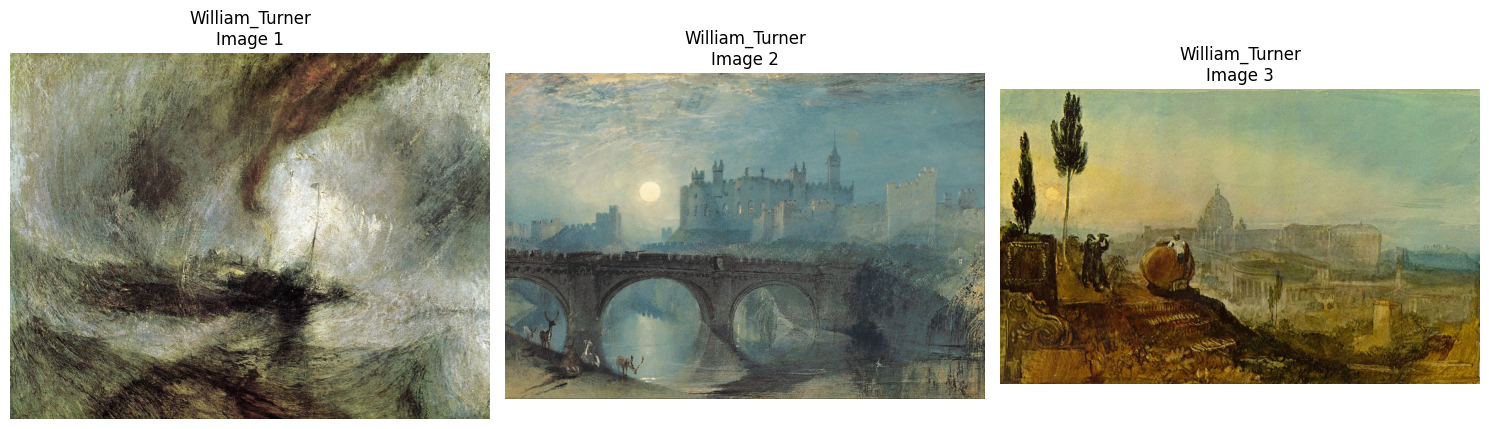


Œuvres de Andrei Rublev:


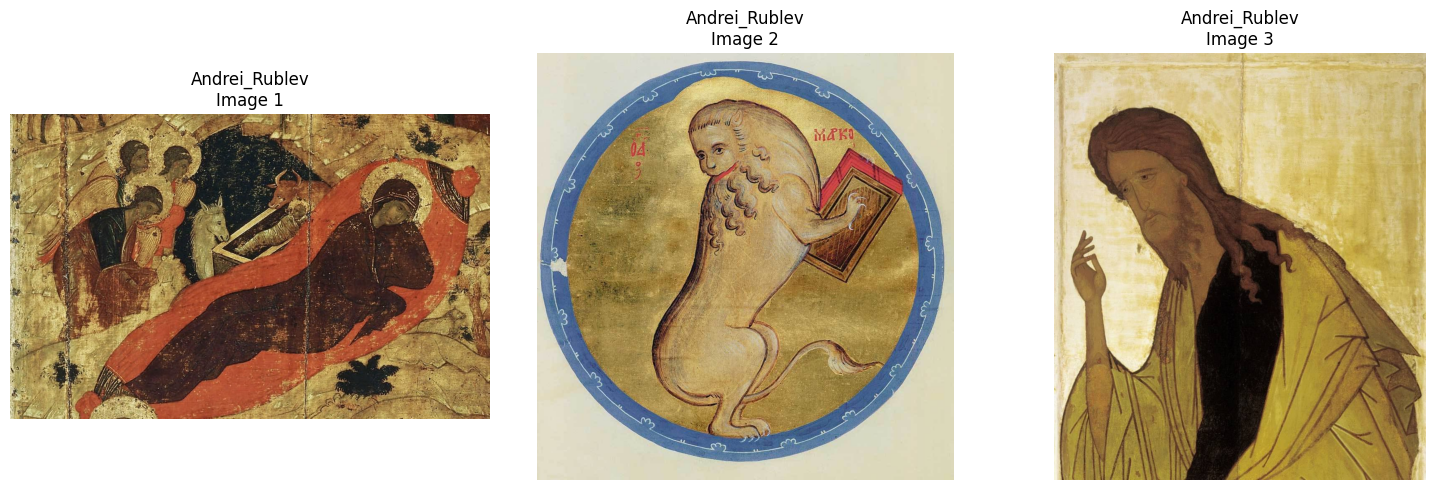


Œuvres de Jan van Eyck:


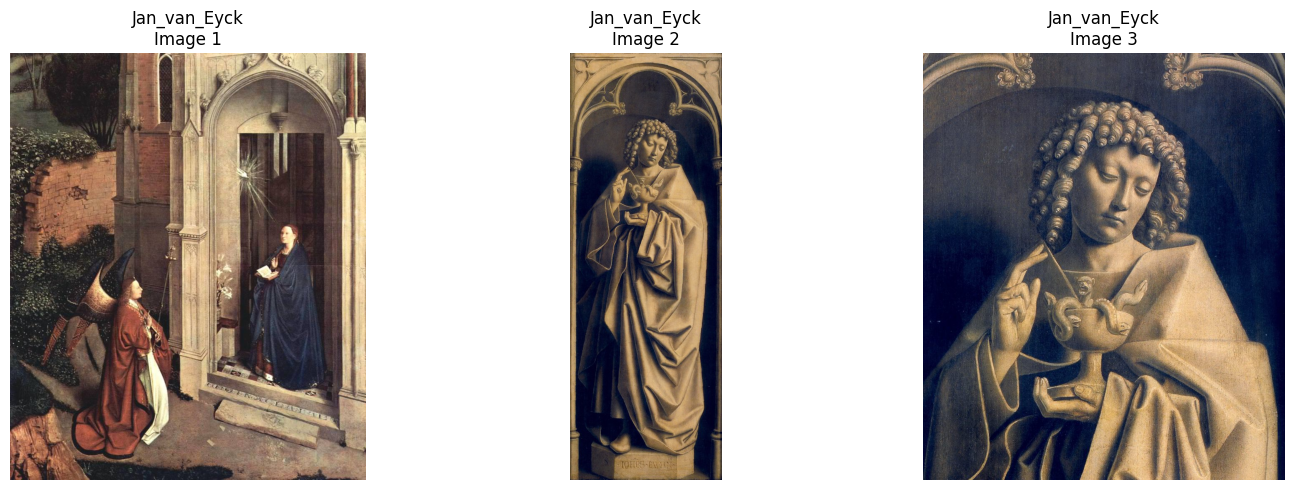


Artistes les plus prolifiques: ['Vincent van Gogh', 'Edgar Degas', 'Pablo Picasso', 'Pierre-Auguste Renoir', 'Albrecht Dürer']
Dataset créé avec 200 images


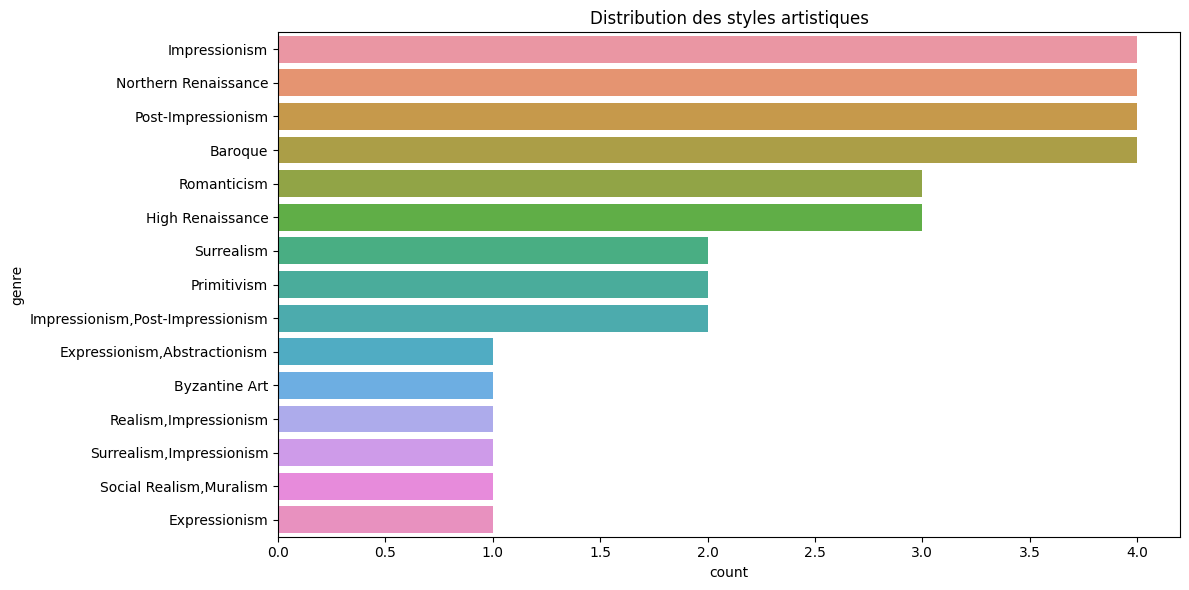


Principaux artistes impressionnistes:
                         name     nationality  paintings
8            Vincent van Gogh           Dutch        877
30                Edgar Degas          French        702
15      Pierre-Auguste Renoir          French        336
46               Paul Gauguin          French        311
20              Alfred Sisley  French,British        259
4               Rene Magritte         Belgian        194
28              Henri Matisse          French        186
35           Camille Pissarro          French         91
6               Edouard Manet          French         90
33  Henri de Toulouse-Lautrec          French         81
3                Claude Monet          French         73


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import random
import json
from tqdm.notebook import tqdm

# Définir les chemins d'accès aux données
BASE_PATH = "/kaggle/input/best-artworks-of-all-time"
IMAGES_PATH = os.path.join(BASE_PATH, "images/images/")
CSV_PATH = os.path.join(BASE_PATH, "artists.csv")

# Charger les données des artistes
artists_df = pd.read_csv(CSV_PATH)
print(f"Nombre total d'artistes: {len(artists_df)}")

# Afficher les premières lignes du dataframe
print(artists_df.head())

# Fonction pour obtenir les images d'un artiste
def get_artist_images(artist_name, max_images=5):
    """
    Récupère les images d'un artiste spécifique
    
    Args:
        artist_name (str): Nom de l'artiste (format dans le dossier)
        max_images (int): Nombre maximum d'images à récupérer
        
    Returns:
        list: Liste des chemins d'images
    """
    artist_dir = os.path.join(IMAGES_PATH, artist_name)
    if not os.path.exists(artist_dir):
        print(f"Répertoire {artist_dir} n'existe pas")
        return []
    
    images = []
    image_files = os.listdir(artist_dir)
    
    # Trier les fichiers par numéro
    image_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]) if x.split('_')[-1].split('.')[0].isdigit() else 0)
    
    # Limiter le nombre d'images
    image_files = image_files[:max_images]
    
    for img_file in image_files:
        img_path = os.path.join(artist_dir, img_file)
        images.append(img_path)
    
    return images

# Fonction pour afficher les images d'un artiste
def show_artist_images(artist_name, max_images=5):
    """
    Affiche les images d'un artiste
    
    Args:
        artist_name (str): Nom de l'artiste (format dans le dossier)
        max_images (int): Nombre maximum d'images à afficher
    """
    images = get_artist_images(artist_name, max_images)
    if not images:
        return
    
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]  # Pour gérer le cas d'une seule image
    
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"{artist_name}\nImage {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Exemple: afficher les informations sur les artistes
print("\nDistribution des genres artistiques:")
print(artists_df['genre'].value_counts().head(10))

print("\nDistribution des nationalités:")
print(artists_df['nationality'].value_counts().head(10))

# Visualiser quelques exemples d'œuvres pour un artiste aléatoire
random_artists = artists_df.sample(3)['name'].tolist()
for artist in random_artists:
    artist_folder_name = artist.replace(' ', '_')
    print(f"\nŒuvres de {artist}:")
    show_artist_images(artist_folder_name, max_images=3)

# Fonction pour créer un dataset PyTorch
class ArtistDataset(torch.utils.data.Dataset):
    def __init__(self, artists_list, transform=None, max_per_artist=50):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.artist_to_idx = {artist: idx for idx, artist in enumerate(artists_list)}
        
        for artist in artists_list:
            artist_folder = artist.replace(' ', '_')
            artist_dir = os.path.join(IMAGES_PATH, artist_folder)
            
            if not os.path.exists(artist_dir):
                continue
                
            image_files = [f for f in os.listdir(artist_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if max_per_artist:
                image_files = image_files[:max_per_artist]
                
            for img_file in image_files:
                img_path = os.path.join(artist_dir, img_file)
                self.image_paths.append(img_path)
                self.labels.append(self.artist_to_idx[artist])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Exemple: créer un dataset pour l'entraînement d'un modèle
def create_artist_style_dataset(selected_artists, img_size=224):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = ArtistDataset(selected_artists, transform=transform)
    print(f"Dataset créé avec {len(dataset)} images")
    return dataset

# Sélectionner quelques artistes populaires
popular_artists = artists_df.sort_values('paintings', ascending=False).head(5)['name'].tolist()
print(f"\nArtistes les plus prolifiques: {popular_artists}")

# Créer un dataset pour ces artistes
dataset = create_artist_style_dataset(popular_artists)

# Visualiser la distribution des styles
plt.figure(figsize=(12, 6))
sns.countplot(y='genre', data=artists_df, order=artists_df['genre'].value_counts().index[:15])
plt.title('Distribution des styles artistiques')
plt.tight_layout()
plt.show()

# Fonction pour trouver des artistes par style
def find_artists_by_style(style, min_paintings=20):
    """
    Trouve des artistes correspondant à un style spécifique
    
    Args:
        style (str): Style artistique recherché
        min_paintings (int): Nombre minimum de peintures
        
    Returns:
        DataFrame: Sous-ensemble des artistes correspondant aux critères
    """
    filtered_df = artists_df[artists_df['genre'].str.contains(style, case=False)]
    filtered_df = filtered_df[filtered_df['paintings'] >= min_paintings]
    return filtered_df.sort_values('paintings', ascending=False)

# Exemple: trouver des artistes impressionnistes
impressionists = find_artists_by_style('Impressionism', min_paintings=50)
print("\nPrincipaux artistes impressionnistes:")
print(impressionists[['name', 'nationality', 'paintings']])

In [9]:
style_descriptions = {
    "Impressionism": "Caractérisé par de petites touches visibles, l'accent sur la lumière, les scènes ordinaires, les couleurs vibrantes et le mouvement. Capture l'impression visuelle momentanée d'une scène plutôt que les détails précis.",
    
    "Post-Impressionism": "Développe les impressions visuelles avec un plus grand accent sur les formes géométriques, la distorsion intentionnelle et des couleurs non naturelles. Préserve l'intensité lumineuse tout en ajoutant une structure plus symbolique.",
    
    "Expressionism": "Met l'accent sur l'émotion subjective plutôt que la réalité objective. Utilise des couleurs intenses, des lignes agitées et des distorsions pour communiquer des sentiments et des idées personnels.",
    
    "Cubism": "Décompose les sujets en formes géométriques abstraites, montrant différentes perspectives simultanément. Réduit les formes à leur essence géométrique avec une palette limitée.",
    
    "Surrealism": "Juxtapose des images oniriques et illogiques pour explorer l'inconscient. Crée des scènes impossibles avec des objets réalistes dans des contextes inattendus.",
    
    "Baroque": "Style dramatique avec un fort contraste clair-obscur, un mouvement dynamique et une richesse de détails. Explore la tension, l'émotion et la grandeur avec une composition souvent diagonale.",
    
    "Renaissance": "Équilibre harmonieux, perspective linéaire et idéaux classiques. Représente la forme humaine avec précision anatomique et utilise la composition triangulaire.",
    
    "Northern Renaissance": "Similaire à la Renaissance italienne mais avec plus d'attention aux détails réalistes, aux textures et à la lumière naturelle. Intègre souvent un symbolisme religieux complexe.",
    
    "High Renaissance": "Maîtrise parfaite de la technique avec équilibre idéal, harmonie et perspective. Représentation idéalisée des figures avec une composition monumentale et élégante.",
    
    "Romanticism": "Privilégie l'émotion, l'individualisme et la nature dramatique. Utilise des couleurs riches et des compositions dynamiques pour évoquer des émotions fortes.",
    
    "Realism": "Représente les sujets avec fidélité visuelle sans idéalisation. Se concentre sur la vie quotidienne et les conditions sociales avec précision et objectivité.",
    
    "Symbolism": "Utilise des images symboliques pour représenter des idées et des émotions. Préfère la suggestion et la métaphore à la description directe.",
    
    "Art Nouveau": "Lignes organiques fluides et motifs naturels stylisés. Intègre formes florales, courbes gracieuses et compositions asymétriques.",
    
    "Byzantine Art": "Figures plates et stylisées avec des fonds dorés. Utilise l'iconographie religieuse rigide avec des proportions non naturalistes et une perspective inversée.",
    
    "Mannerism": "Distorsion délibérée des proportions pour l'effet dramatique. Compositions complexes avec des poses exagérées et des couleurs non naturelles.",
    
    "Primitivism": "S'inspire de l'art naïf et tribal. Utilise des formes simplifiées, des couleurs plates et rejet des conventions académiques.",
    
    "Social Realism": "Dépeint les conditions sociales des classes laborieuses et défavorisées. Critique sociale à travers des scènes du quotidien.",
    
    "Muralism": "Peintures monumentales intégrées à l'architecture publique. Traite souvent de thèmes sociaux, politiques et historiques.",
    
    "Abstractionism": "Rejette la représentation figurative en faveur de formes, couleurs et lignes pures. L'art existe indépendamment de références visuelles au monde réel.",
    
    "Suprematism": "Art abstrait basé sur formes géométriques fondamentales et couleurs limitées. Recherche la pureté et la sensation plutôt que la représentation.",
    
    "Neoplasticism": "Réduction à l'essentiel avec lignes droites, couleurs primaires et formes rectangulaires. Équilibre visuel par la composition orthogonale.",
    
    "Abstract Expressionism": "Spontanéité gestuelle et expression émotionnelle à travers l'abstraction. Valorise l'acte physique de peindre et le subconscient.",
    
    "Pop Art": "S'approprie les images de la culture populaire et de la publicité. Utilise des couleurs vives, des contours nets et souvent l'ironie."
}


In [10]:
def create_artist_description(artist_row):
    name = artist_row['name']
    genre_list = artist_row['genre'].split(',')
    nationality = artist_row['nationality']
    years = artist_row['years']
    paintings_count = artist_row['paintings']
    
    # Construire la description principale
    description = f"{name} ({years}) était un artiste {nationality} associé principalement "
    
    if len(genre_list) == 1:
        description += f"au mouvement {genre_list[0]}. "
    else:
        description += f"aux mouvements {' et '.join(genre_list)}. "
    
    # Ajouter une description pour chaque style de l'artiste
    for style in genre_list:
        style = style.strip()
        if style in style_descriptions:
            description += f"Son œuvre {style.lower()} {style_descriptions[style]} "
    
    # Ajouter le nombre d'œuvres
    description += f"\n\nLe dataset contient {paintings_count} peintures de cet artiste. "
    
    return description

# Fonction pour obtenir les caractéristiques visuelles des images d'un artiste
def analyze_artist_images(artist_name, sample_size=10):
    artist_folder = artist_name.replace(' ', '_')
    artist_dir = os.path.join(IMAGES_PATH, artist_folder)
    
    if not os.path.exists(artist_dir):
        return "Pas d'images disponibles pour l'analyse."
    
    # Obtenir tous les fichiers image
    image_files = [f for f in os.listdir(artist_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Limiter l'échantillon si nécessaire
    if len(image_files) > sample_size:
        image_files = random.sample(image_files, sample_size)
    
    # Caractéristiques visuelles à analyser
    colors = []
    brightness_values = []
    contrast_values = []
    
    for img_file in image_files:
        img_path = os.path.join(artist_dir, img_file)
        try:
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img)
            
            # Analyser les couleurs dominantes
            avg_color = img_array.mean(axis=(0, 1))
            colors.append(avg_color)
            
            # Analyser la luminosité
            brightness = img_array.mean()
            brightness_values.append(brightness)
            
            # Analyser le contraste (écart-type simple)
            contrast = img_array.std()
            contrast_values.append(contrast)
            
        except Exception as e:
            print(f"Erreur lors de l'analyse de {img_path}: {e}")
    
    if not colors:
        return "Impossible d'analyser les images."
    
    # Calculer les moyennes
    avg_colors = np.mean(colors, axis=0)
    avg_brightness = np.mean(brightness_values)
    avg_contrast = np.mean(contrast_values)
    
    # Interpréter les résultats
    color_desc = ""
    if avg_colors[0] > avg_colors[1] and avg_colors[0] > avg_colors[2]:
        color_desc = "tendance vers les rouges et les tons chauds"
    elif avg_colors[1] > avg_colors[0] and avg_colors[1] > avg_colors[2]:
        color_desc = "dominance de verts et de tons naturels"
    elif avg_colors[2] > avg_colors[0] and avg_colors[2] > avg_colors[1]:
        color_desc = "prédominance de bleus et de tons froids"
    else:
        color_desc = "palette équilibrée entre les couleurs primaires"
    
    brightness_desc = ""
    if avg_brightness < 80:
        brightness_desc = "œuvres généralement sombres"
    elif avg_brightness < 150:
        brightness_desc = "luminosité moyenne"
    else:
        brightness_desc = "œuvres généralement lumineuses"
    
    contrast_desc = ""
    if avg_contrast < 50:
        contrast_desc = "contraste faible"
    elif avg_contrast < 80:
        contrast_desc = "contraste modéré"
    else:
        contrast_desc = "fort contraste"
    
    analysis = f"L'analyse visuelle des œuvres révèle une {color_desc}, avec des {brightness_desc} et un {contrast_desc}."
    return analysis

In [11]:
all_descriptions = {}

print("Génération des descriptions pour les 50 artistes...")
for idx, artist in tqdm(artists_df.iterrows(), total=len(artists_df)):
    artist_name = artist['name']
    
    # Description de base sur le style et la carrière
    base_description = create_artist_description(artist)
    
    # Analyse visuelle des œuvres
    visual_analysis = analyze_artist_images(artist_name)
    
    # Combiner les descriptions
    full_description = base_description + "\n\n" + visual_analysis
    
    # Stocker la description
    all_descriptions[artist_name] = full_description

# Exemple d'affichage pour quelques artistes
sample_artists = random.sample(list(all_descriptions.keys()), 3)
print("\nExemples de descriptions générées:")
for artist in sample_artists:
    print(f"\n{'='*50}\n{artist}\n{'='*50}")
    print(all_descriptions[artist])

# Sauvegarder toutes les descriptions dans un fichier JSON
with open('artist_descriptions.json', 'w', encoding='utf-8') as f:
    json.dump(all_descriptions, f, ensure_ascii=False, indent=4)

print("\nToutes les descriptions ont été sauvegardées dans 'artist_descriptions.json'")

Génération des descriptions pour les 50 artistes...


  0%|          | 0/50 [00:00<?, ?it/s]


Exemples de descriptions générées:

Paul Cezanne
Paul Cezanne (1839 – 1906) était un artiste French associé principalement au mouvement Post-Impressionism. Son œuvre post-impressionism Développe les impressions visuelles avec un plus grand accent sur les formes géométriques, la distorsion intentionnelle et des couleurs non naturelles. Préserve l'intensité lumineuse tout en ajoutant une structure plus symbolique. 

Le dataset contient 47 peintures de cet artiste. 

L'analyse visuelle des œuvres révèle une tendance vers les rouges et les tons chauds, avec des luminosité moyenne et un contraste modéré.

Joan Miro
Joan Miro (1893 – 1983) était un artiste Spanish associé principalement au mouvement Surrealism. Son œuvre surrealism Juxtapose des images oniriques et illogiques pour explorer l'inconscient. Crée des scènes impossibles avec des objets réalistes dans des contextes inattendus. 

Le dataset contient 102 peintures de cet artiste. 

L'analyse visuelle des œuvres révèle une tendance 

In [12]:
def create_image_descriptions(artist_name, max_images=5):
    artist_folder = artist_name.replace(' ', '_')
    artist_dir = os.path.join(IMAGES_PATH, artist_folder)
    
    if not os.path.exists(artist_dir):
        return {}
    
    # Obtenir tous les fichiers image
    image_files = [f for f in os.listdir(artist_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]) if x.split('_')[-1].split('.')[0].isdigit() else 0)
    
    # Limiter le nombre d'images
    image_files = image_files[:max_images]
    
    # Style de l'artiste
    artist_row = artists_df[artists_df['name'] == artist_name].iloc[0]
    genres = artist_row['genre'].split(',')
    main_genre = genres[0].strip()
    
    # Éléments visuels typiques par genre
    genre_elements = {
        "Impressionism": ["coup de pinceau visible", "jeu de lumière", "scène de plein air", "couleurs vibrantes", "ambiance atmosphérique"],
        "Post-Impressionism": ["couleurs expressives", "formes simplifiées", "perspective non conventionnelle", "contours marqués", "symbolisme"],
        "Expressionism": ["distorsion émotionnelle", "couleurs intenses", "lignes anguleuses", "expression de sentiments", "atmosphère troublante"],
        "Cubism": ["formes géométriques", "perspectives multiples", "plans fragmentés", "palette limitée", "analyse de la forme"],
        "Surrealism": ["juxtaposition illogique", "éléments oniriques", "symbolisme personnel", "technique précise", "inconscient"],
        "Baroque": ["clair-obscur dramatique", "composition diagonale", "mouvement dynamique", "détails somptueux", "émotion intense"],
        "Northern Renaissance": ["détails minutieux", "réalisme", "symbolisme religieux", "texture précise", "lumière naturelle"],
        "High Renaissance": ["composition équilibrée", "perspective parfaite", "idéalisation des figures", "harmonie", "anatomie précise"],
        "Romanticism": ["émotion dramatique", "nature sublime", "couleurs intenses", "mouvement", "individualisme"],
        "Realism": ["détails du quotidien", "scènes de la vie ordinaire", "précision", "objectivité", "critique sociale"],
        "Symbolism": ["métaphore visuelle", "signification cachée", "figures mythologiques", "éléments décoratifs", "spiritualité"],
        "Abstract Expressionism": ["geste spontané", "absence de forme reconnaissable", "expression pure", "texture", "action painting"],
        "Pop Art": ["imagerie populaire", "couleurs vives", "techniques commerciales", "ironie", "reproduction mécanique"]
    }
    
    # Éléments par défaut si le genre n'est pas dans la liste
    default_elements = ["composition", "couleur", "thème", "technique", "expression"]
    
    # Obtenir les éléments du genre principal
    elements = genre_elements.get(main_genre, default_elements)
    
    image_descriptions = {}
    
    for img_file in image_files:
        img_path = os.path.join(artist_dir, img_file)
        try:
            img = Image.open(img_path)
            img_array = np.array(img)
            
            # Analyser l'image
            brightness = img_array.mean()
            color_dominance = img_array.mean(axis=(0, 1))
            
            # Déterminer les caractéristiques visuelles
            if brightness < 80:
                tone = "sombre"
            elif brightness < 150:
                tone = "modéré"
            else:
                tone = "lumineux"
                
            # Déterminer la couleur dominante
            if color_dominance[0] > color_dominance[1] and color_dominance[0] > color_dominance[2]:
                dominant_color = "rouge"
            elif color_dominance[1] > color_dominance[0] and color_dominance[1] > color_dominance[2]:
                dominant_color = "vert"
            elif color_dominance[2] > color_dominance[0] and color_dominance[2] > color_dominance[1]:
                dominant_color = "bleu"
            else:
                dominant_color = "équilibré"
            
            # Choisir aléatoirement 2-3 éléments caractéristiques du style
            selected_elements = random.sample(elements, min(3, len(elements)))
            
            # Créer une description pour cette image
            description = f"Cette œuvre de {artist_name} illustre son style {main_genre}. "
            description += f"La toile présente un ton général {tone} avec une dominance de {dominant_color}. "
            description += f"On y observe clairement {', '.join(selected_elements[:-1])} et {selected_elements[-1]}, "
            description += f"caractéristiques emblématiques de son travail."
            
            image_descriptions[img_file] = description
            
        except Exception as e:
            print(f"Erreur lors de l'analyse de {img_path}: {e}")
    
    return image_descriptions

In [13]:
sample_for_images = random.sample(artists_df['name'].tolist(), 5)
all_image_descriptions = {}

print("\nGénération des descriptions d'images spécifiques...")
for artist in tqdm(sample_for_images):
    image_descriptions = create_image_descriptions(artist)
    all_image_descriptions[artist] = image_descriptions

# Exemple d'affichage de descriptions d'images
print("\nExemples de descriptions d'images spécifiques:")
for artist, descriptions in all_image_descriptions.items():
    print(f"\n{'='*50}\n{artist}\n{'='*50}")
    for img_name, desc in list(descriptions.items())[:2]:  # Afficher seulement 2 images par artiste
        print(f"\n{img_name}:")
        print(desc)

# Sauvegarder les descriptions d'images dans un fichier JSON
with open('image_descriptions.json', 'w', encoding='utf-8') as f:
    json.dump(all_image_descriptions, f, ensure_ascii=False, indent=4)

print("\nLes descriptions d'images ont été sauvegardées dans 'image_descriptions.json'")


Génération des descriptions d'images spécifiques...


  0%|          | 0/5 [00:00<?, ?it/s]


Exemples de descriptions d'images spécifiques:

Giotto di Bondone

Giotto_di_Bondone_1.jpg:
Cette œuvre de Giotto di Bondone illustre son style Proto Renaissance. La toile présente un ton général modéré avec une dominance de rouge. On y observe clairement thème, expression et technique, caractéristiques emblématiques de son travail.

Giotto_di_Bondone_2.jpg:
Cette œuvre de Giotto di Bondone illustre son style Proto Renaissance. La toile présente un ton général modéré avec une dominance de rouge. On y observe clairement thème, technique et expression, caractéristiques emblématiques de son travail.

Leonardo da Vinci

Leonardo_da_Vinci_1.jpg:
Cette œuvre de Leonardo da Vinci illustre son style High Renaissance. La toile présente un ton général modéré avec une dominance de rouge. On y observe clairement composition équilibrée, perspective parfaite et anatomie précise, caractéristiques emblématiques de son travail.

Leonardo_da_Vinci_2.jpg:
Cette œuvre de Leonardo da Vinci illustre son st

In [14]:
from huggingface_hub import login
login() 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (155 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["et la grandeur avec une composition souvent diagonale . le dataset contient 1 2 8 peintures de cet artiste . l ' analyse visuelle des œuvres révèle une tendance vers les rouges et les tons chauds , avec des œuvres généralement sombres et un contraste modéré ."]


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["et des couleurs non naturelles . préserve l ' intensité lumineuse tout en ajoutant une structure plus symbolique . le dataset contient 4 7 peintures de cet artiste . l ' analyse visuelle des œuvres révèle une tendance vers les rouges et les tons chauds , avec des luminosité moyenne et un contraste modéré ."]


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["alistes dans des contextes inattendus . son œuvre impressionism caractérisé par de petites touches visibles , l ' accent sur la lumière , les scènes ordinaires , les couleurs vibrantes et le mouvement . capture l ' impression visuelle momentanée d ' une scène plutôt que les détails précis . le dataset contient 1 9 4 peintures de cet artiste . l ' analyse visuelle des œuvres révèle une tendance vers les rouges et les tons chauds , avec des luminosité moyenne et un contraste modéré ."]


  0%|          | 0/50 [00:00<?, ?it/s]

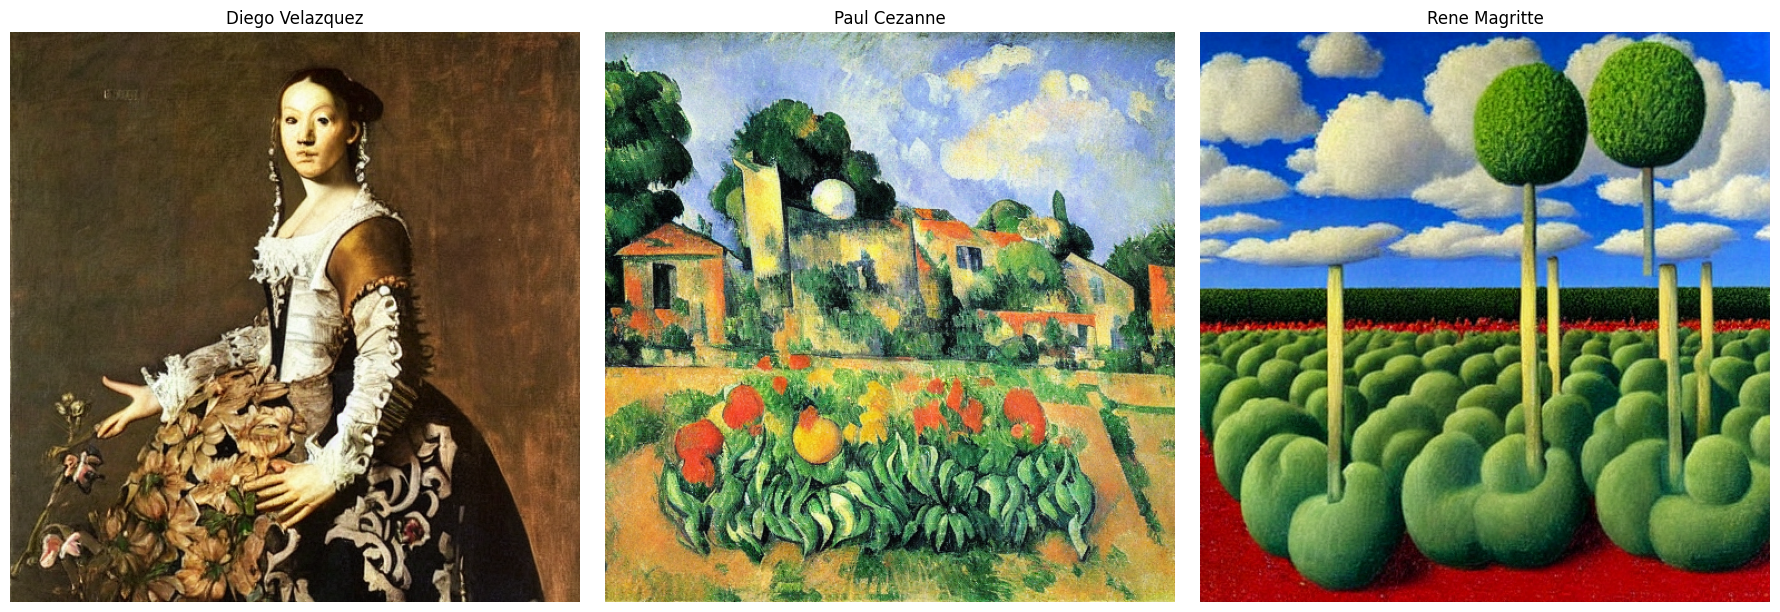

In [16]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from PIL import Image
import random
import json

# Charger les descriptions des artistes
with open("/kaggle/working/artist_descriptions.json", "r", encoding="utf-8") as f:
    artist_descriptions = json.load(f)

# Liste de quelques artistes présents dans le fichier JSON
available_artists = list(artist_descriptions.keys())
# Exemple de prompt générique
prompt = "Fleur dans jardin"

# Charger le modèle Stable Diffusion 1.5
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.to("cuda")

# Générer une image à partir d’un prompt + description du style de l’artiste
def generate_image_with_style(prompt, artist):
    style_description = artist_descriptions.get(artist, "")
    full_prompt = f"{prompt}, {style_description}"
    image = pipe(full_prompt).images[0]
    return image

# Afficher les images avec style
def display_images_with_styles(prompt, artists):
    fig, axes = plt.subplots(1, len(artists), figsize=(18, 6))
    for i, artist in enumerate(artists):
        img = generate_image_with_style(prompt, artist)
        axes[i].imshow(img)
        axes[i].set_title(f"{artist}", fontsize=12)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Sélectionner 3 artistes aléatoirement depuis les données JSON
selected_artists = random.sample(available_artists, 3)

# Afficher les images générées
display_images_with_styles(prompt, selected_artists)
